In [2]:
# Reload required libraries after kernel reset
import pandas as pd

# Load only the first 1000 rows from sheet
excel_path = 'online_retail_II.xlsx'
xl = pd.read_excel(excel_path, sheet_name='Year 2009-2010', nrows=1000)
# show first few rows
xl.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# show basic info
xl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      1000 non-null   object        
 1   StockCode    1000 non-null   object        
 2   Description  999 non-null    object        
 3   Quantity     1000 non-null   int64         
 4   InvoiceDate  1000 non-null   datetime64[ns]
 5   Price        1000 non-null   float64       
 6   Customer ID  994 non-null    float64       
 7   Country      1000 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 62.6+ KB


Clean DATA

In [4]:
# Filtering out rows with non-positive quantity or price
xl = xl[(xl['Quantity'] > 0) & (xl['Price'] > 0)]

# Drop rows with missing values in 'Customer ID' or 'Description'
xl = xl.dropna(subset=['Customer ID', 'Description'])

# Create a new column for total price
xl['TotalPrice'] = xl['Quantity'] * xl['Price']

# Convert 'InvoiceData' to datetime if not already
xl['InvoiceDate'] = pd.to_datetime(xl['InvoiceDate'])

# Provide the cleaned data
xl.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

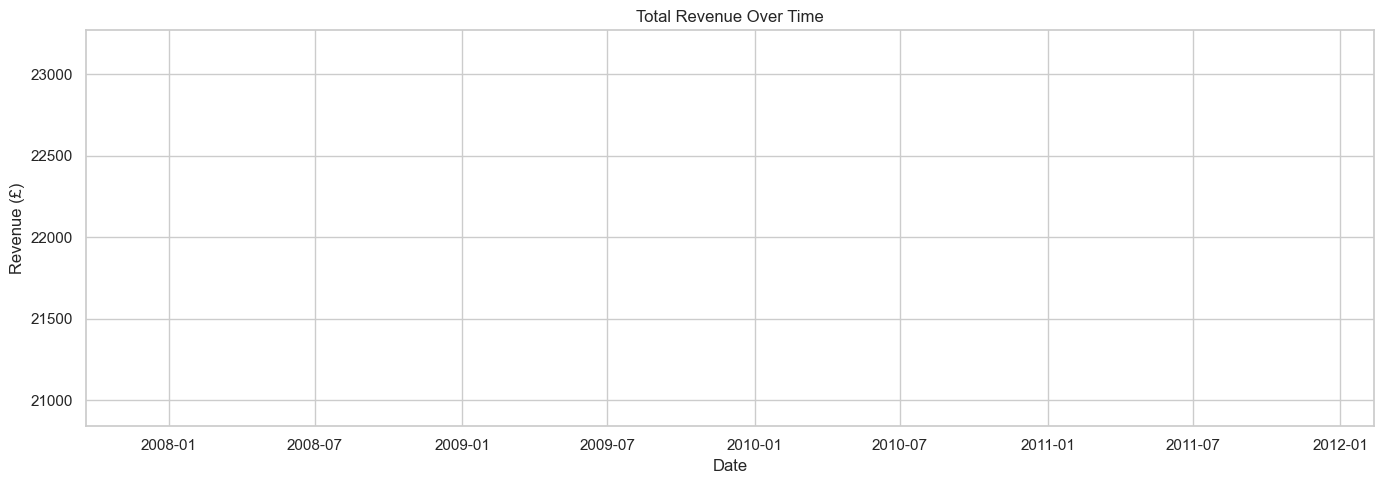

In [6]:
sales_by_date = xl.groupby(xl['InvoiceDate'].dt.date)['TotalPrice'].sum()

plt.figure(figsize=(14, 5))
sales_by_date.plot()
plt.title("Total Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue (£)")
plt.tight_layout()
plt.show()

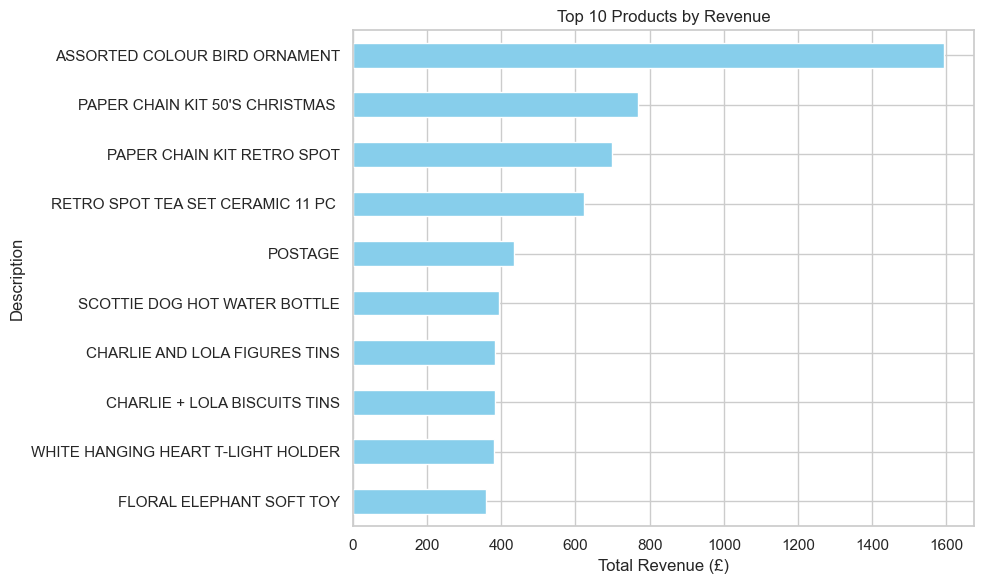

In [7]:
top_products = xl.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_products.plot(kind='barh', color='skyblue')
plt.title("Top 10 Products by Revenue")
plt.xlabel("Total Revenue (£)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

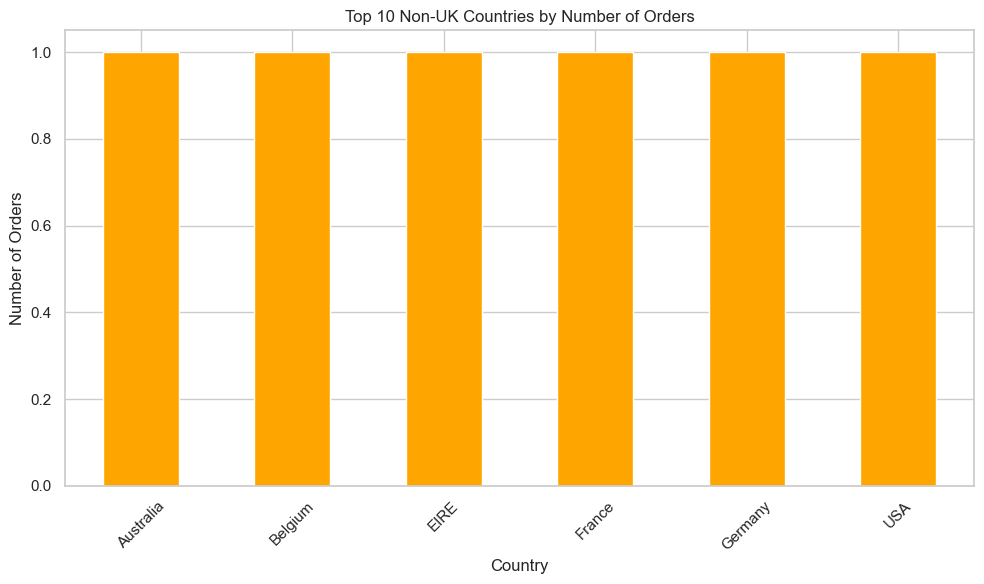

In [8]:
orders_by_country = xl[xl['Country'] != 'United Kingdom'].groupby('Country')['Invoice'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
orders_by_country.plot(kind='bar', color='orange')
plt.title("Top 10 Non-UK Countries by Number of Orders")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
import datetime as dt

# Set a reference date for Recency calculation (e.g., one day after the last invoice)
reference_date = xl['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM Table
rfm = xl.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
})

# Optional: Remove customers with negative or zero Monetary value (just in case)
rfm = rfm[rfm['Monetary'] > 0]

# RFM Scoring (1 = worst, 5 = best)
# Use qcut safely by dropping duplicate bin edges
# Recency score: lower recency = better score
rfm['R'] = pd.cut(rfm['Recency'],
                  bins=[-1, 7, 14, 30, 60, float('inf')],
                  labels=[5, 4, 3, 2, 1])

# Frequency score: higher frequency = better score
rfm['F'] = pd.cut(rfm['Frequency'],
                  bins=[0, 1, 2, 4, 7, float('inf')],
                  labels=[1, 2, 3, 4, 5])

# Monetary score: higher spending = better score
rfm['M'] = pd.cut(rfm['Monetary'],
                  bins=[0, 50, 100, 200, 500, float('inf')],
                  labels=[1, 2, 3, 4, 5])

# Combine into RFM score
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].astype(str).agg(''.join, axis=1)

# Show the result
rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
Customer ID,,,,,,,
12362.0,1,1,130.00,5,1,3,513
12533.0,1,1,929.92,5,1,5,515
12636.0,1,1,141.00,5,1,3,513
12682.0,1,1,426.30,5,1,4,514
12913.0,1,1,537.96,5,1,5,515


RFM data modeling

In [10]:
from sklearn.preprocessing import StandardScaler

# Use numaric RFM columns
rfm_numeric = rfm[['Recency', 'Frequency', 'Monetary']]

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_numeric)

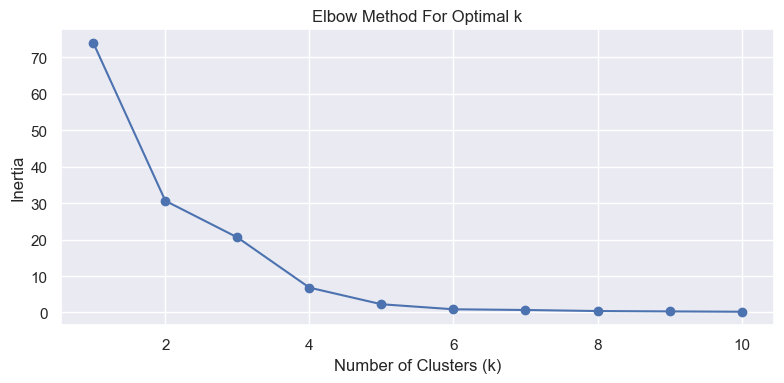

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # or any number of CPU cores you want to use


# Try K=1 to K=10
inertia = []
K_range = range(1, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.tight_layout()
plt.show()

KMeans Model

In [13]:
# Fit the KMeans model
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Preview with cluster
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Cluster
Customer ID,,,,,,,,
12362.0,1,1,130.00,5,1,3,513,0
12533.0,1,1,929.92,5,1,5,515,2
12636.0,1,1,141.00,5,1,3,513,0
12682.0,1,1,426.30,5,1,4,514,0
12913.0,1,1,537.96,5,1,5,515,0


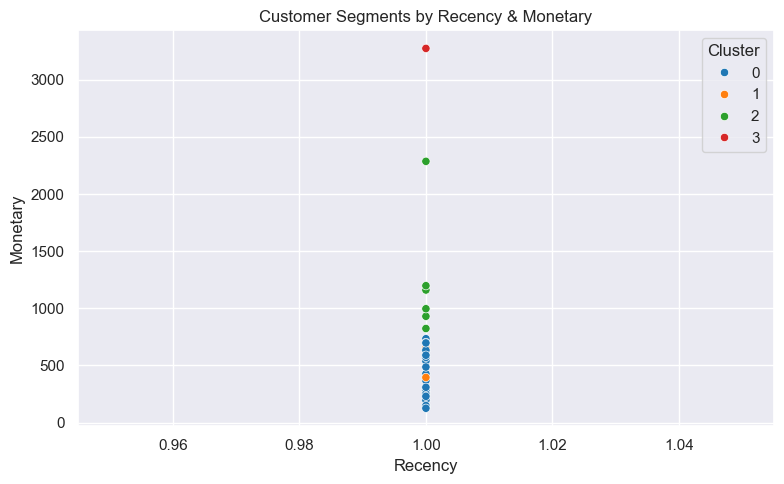

In [14]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10')
plt.title("Customer Segments by Recency & Monetary")
plt.tight_layout()
plt.show()


 Calculate Average RFM Values by Cluster

In [18]:
# Convert cluster column to int (for readability)
rfm['Cluster'] = rfm['Cluster'].astype(int)

# Get average metrics per cluster
# Get average metrics per cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

# Add count of customers per cluster
cluster_summary['Count'] = rfm.groupby('Cluster').size()

cluster_summary

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,1.0,1.0,369.3,28
1,1.0,2.0,522.9,2
2,1.0,1.0,1232.2,6
3,1.0,2.0,3274.7,1


In [19]:
segment_labels = {
    0: 'Loyal Customers',
    1: 'Occasional Buyers',
    2: 'Potential Loyalists',
    3: 'Churn Risk'
}

rfm['Segment'] = rfm['Cluster'].map(segment_labels)


In [20]:
# Save to CSV
rfm.to_csv('rfm_segmented_customers.csv', index=False)


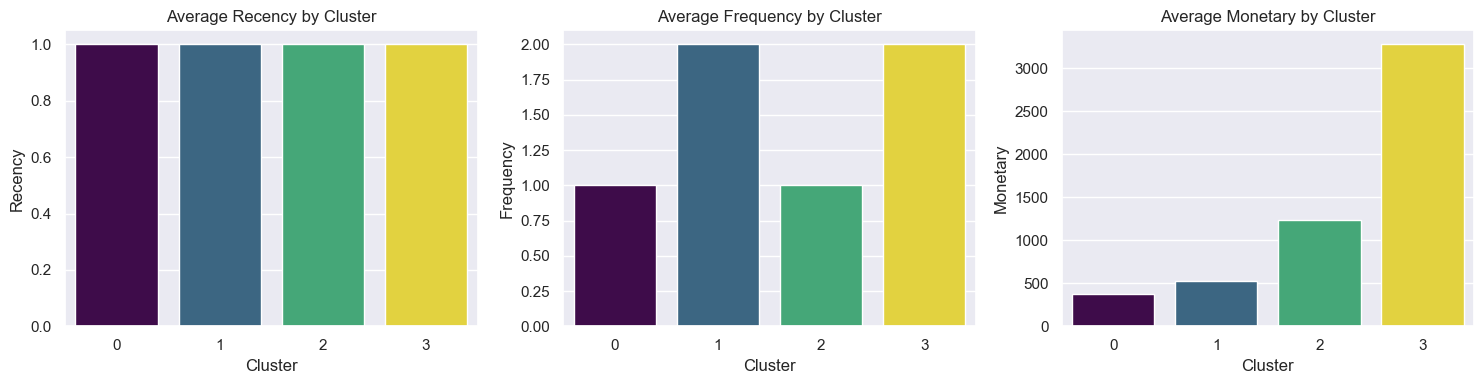

In [22]:
# Reset index so 'Cluster' becomes a column
cluster_summary_reset = cluster_summary.reset_index()

# Plot each metric
metrics = ['Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(15, 4))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.barplot(data=cluster_summary_reset, x='Cluster', y=metric, hue='Cluster', palette='viridis', legend=False)

    plt.title(f'Average {metric} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()


Add Labels

In [23]:
def segment_customers(row):
    if row['Cluster'] == 0:
        return 'Loyal Customers'
    elif row['Cluster'] == 1:
        return 'At Risk'
    elif row['Cluster'] == 2:
        return 'New Customers'
    elif row['Cluster'] == 3:
        return 'Big Spenders'
    elif row['Cluster'] == 4:
        return 'Potential Loyalists'
    else:
        return 'Other'

rfm['Segment'] = rfm.apply(segment_customers, axis=1)

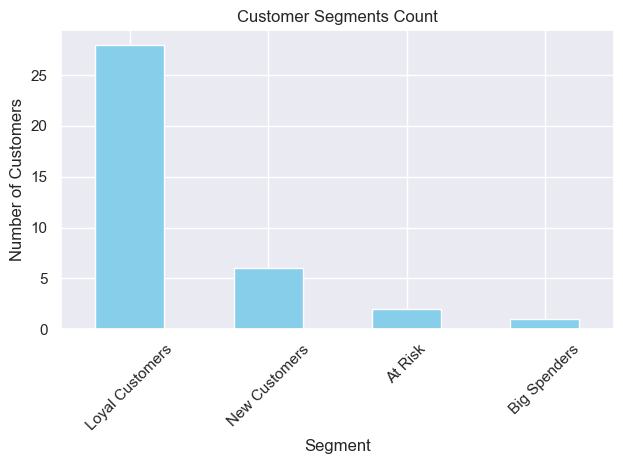

In [24]:
rfm['Segment'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Customer Segments Count')
plt.ylabel('Number of Customers')
plt.xlabel('Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Export the Final RFM Table with Segments

In [25]:
# Save to CSV
rfm.to_csv("rfm_customer_segments.csv", index=False)

# Optional: Save to Excel
rfm.to_excel("rfm_customer_segments.xlsx", index=False)

In [39]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Load RFM data
rfm = pd.read_csv("rfm_customer_segments.csv")

# Check if required columns exist
expected_columns = {'Recency', 'Frequency', 'Monetary', 'Segment'}

missing = expected_columns - set(rfm.columns)

if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# Initialize Dash app
app = dash.Dash(__name__)
app.title = "Customer Segmentation Dashboard"

# App layout
app.layout = html.Div([
    html.H1("Customer Segmentation (RFM)", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Select Metric:"),
        dcc.Dropdown(
            id='metric-dropdown',
            options=[
                {'label': 'Recency', 'value': 'Recency'},
                {'label': 'Frequency', 'value': 'Frequency'},
                {'label': 'Monetary', 'value': 'Monetary'},
            ],
            value='Recency',
            clearable=False
        )
    ], style={'width': '50%', 'margin': 'auto'}),

    dcc.Graph(id='bar-graph')
])


# Callback to update graph
@app.callback(
    Output('bar-graph', 'figure'),
    Input('metric-dropdown', 'value')
)
def update_graph(selected_metric):
    # Group and calculate averages
    cluster_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index().rename(columns={'CustomerID': 'Count'})


    # Create bar chart
    fig = px.bar(
        cluster_summary,
        x='Segment',
        y=selected_metric,
        color='Segment',
        title=f'Average {selected_metric} per Segment',
        text_auto='.2s'
    )

    fig.update_layout(transition_duration=500)
    return fig


# Run server
if __name__ == '__main__':
    app.run(debug=True)